# Adding Cloud Opacity, Scattering, Assymetry


Clouds play a critical role in shaping your reflected light spectrum. 

Until it's release, we will guide you through the file format of the cloud input.

In [1]:
import numpy as np
import pandas as pd

#picaso
from picaso import justdoit as jdi 
from picaso import justplotit as jpi

jpi.output_notebook()

Loading BokehJS ...

Start with the same inputs as before

In [2]:
opa = jdi.opannection(wave_range=[0.3,1])
case1 = jdi.inputs()

In [3]:
#phase 
case1.phase_angle(0) #radians

#gravity 
case1.gravity(gravity = 25, gravity_unit=jdi.u.Unit('m/(s**2)'))

#star
case1.star(opa, 6000,0.0122,4.437) #kelvin, log metal, log cgs

#atmosphere
case1.atmosphere(filename= jdi.jupiter_pt(), sep=r'\s+')

## User Defined Cloud Input

Just as with the Jupiter PT, we will use a Jupiter cloud profile as a demo. This should also be included in your base_cases reference file directory.

In [4]:
print( jdi.jupiter_cld())

/Users/nbatalh1/Documents/codes/PICASO/picaso/reference/base_cases/jupiterf3.cld


In [5]:
#set model clouds
case1.clouds( filename= jdi.jupiter_cld(), sep=r'\s+')

In [6]:
#run 
df = case1.spectrum(opa)
wno, alb, fpfs = df['wavenumber'] , df['albedo'] , df['fpfs_reflected'] 
wno, alb = jdi.mean_regrid(wno, alb, R=150)

In [7]:
jpi.show(jpi.spectrum(wno, alb, plot_width=500))

**Huge** difference from our cloud free cases. High altitude water clouds have increased the albedo dramatically. Let's make sure we understand what is going on with the input file

### File format for user defined input

We define our cloud properties by : 

1) **g0** : Asymmetry factor of the cloud (value between 0 - 1)

2) **w0** : Single scattering albedo (value between 0 - 1)

3) **opd** : Total extinction (tau) of each layer (**not** cumulative) 


#### Cloud file specifications from a model (such as `virga`)

1) Pressure and temperature are specified at the **boundaries** of each level. Cloud parameters are specified for each slab. Therefore, your cloud file should have **(number of PT points -1) layers**. 

2) Cloud files are pressure AND wavelength dependent. The file format could look something like this: 

    nlayer nwave pressure wavenumber w0 g0 opd
    
    1      1     #  #  #  #  # 
    
    1      2     #  #  #  #  # 
    
    1      3     #  #  #  #  # 
    
    .      .     .  .  .  .  .
    
    1      nwno  .  .  .
    
    2      1     .  .  .
    
    2      2     .  .  .
    
    2      3     .  .  .
    
    .      .     .  .  .
    
    .      .     .  .  .
    
    .      .     .  .  .
    
    npt-1  nwno  .  .  .  .  .

3)  It's assumed that these pressure grids correspond to your atmospheric grid. You will see errors through if #cld points != #atmo points - 1 

4) You only have to speciy wavenumber grid if you aren't using `eddysed`

Let's look at the premade example to make sure we understand. Since this is from `eddysed`, and since i know my pressure grid is the same as my previous input, I don't have to have columns for pressure and temperature

In [8]:
#Let's look at the premade example
cld = pd.read_csv(jdi.jupiter_cld(),sep=r'\s+')
cld.head()
#note, it is not required that lvl wv and sigma be in there

,lvl,wv,opd,g0,w0,sigma
0,1,1,0.0,0.0,0.0,0.0
1,1,2,0.0,0.0,0.0,0.0
2,1,3,0.0,0.0,0.0,0.0
3,1,4,0.0,0.0,0.0,0.0
4,1,5,0.0,0.0,0.0,0.0


### Plotting Cloud Input

It's always good to make sure you intuitievly understand what is going on in your input before you create your spectrum. 

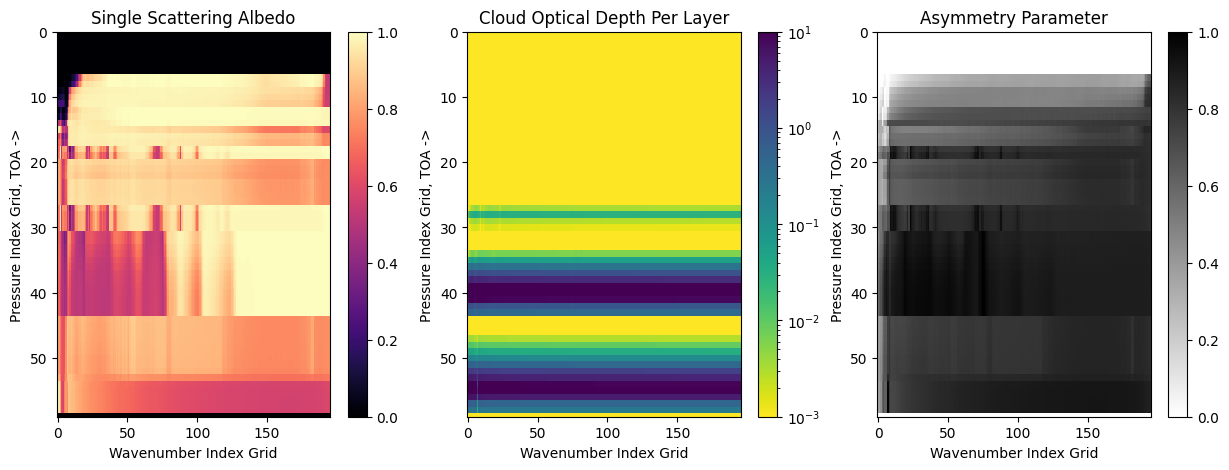

In [9]:
nwno = 196 #this is the default number for A&M cloud code (see below if your wave grid is different)
nlayer = 60 #one less than the number of PT points in your input 
fig = jpi.plot_cld_input( nwno, nlayer,filename=jdi.jupiter_cld(),sep=r'\s+')

The dark regions of the cloud optical depth plot specify where the bulk of the cloud opacity is. The light regions of the single scattering plot, indicate regions of wavenumber where your atmosphere is highly scattering.

## Cloud Input for Using Single Parameter Box Model

Sometimes we are looking for something simpler than a full cloud model. In these cases we can speciy our cloud layer with `g0`, `w0`, `opd` and then `p` (the pressure level in log10 bars) and `dp` (the cloud thickness also in log10 bars)

$\mathrm{cloud\_base(bars)} = 10^{p}$

$\mathrm{cloud\_top(bars)} = 10^{p-dp}$

**`dp` should never be negative!**


In [10]:
#set model clouds, note these are lists since you can specify multiple cloud layers
case1.clouds( g0=[0.9], w0=[0.8], opd=[0.5], p = [0.0], dp=[1.0])  # Slab cloud from 1.0 bar up to 0.1 bar

### Plotting simple cloud profile

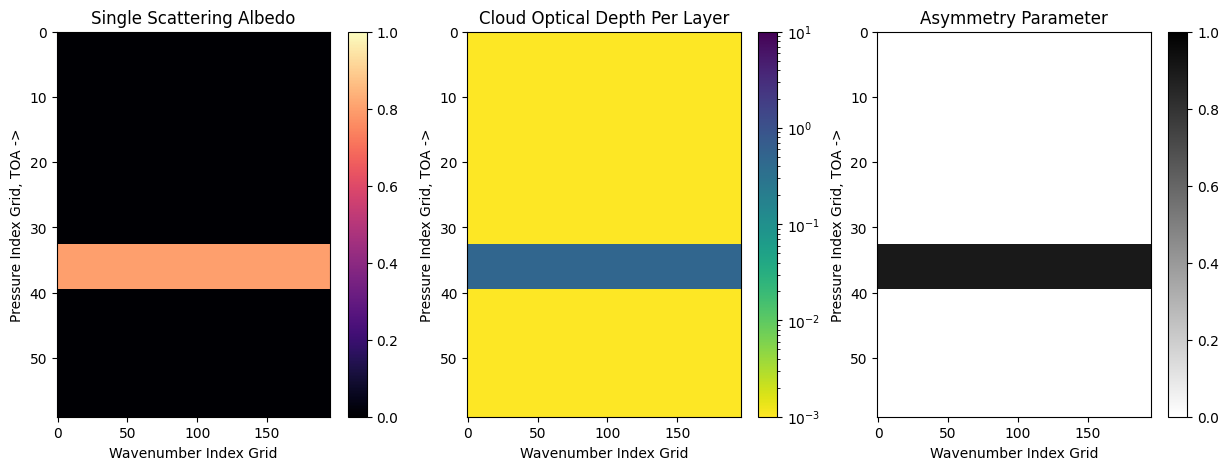

In [15]:
nwno = 196 #this is the default number for A&M cloud code (see below if your wave grid is different)
fig = jpi.plot_cld_input(nwno, nlayer,df=case1.inputs['clouds']['profile'])

In [13]:
df = case1.spectrum(opa,full_output=True)
wno, alb, fpfs = df['wavenumber'] , df['albedo'] , df['fpfs_reflected'] 
wno, alb = jdi.mean_regrid(wno, alb, R=150)
jpi.show(jpi.spectrum(wno, alb, plot_width=500))

### Plot cloud from output data

In [ ]:
fig=jpi.cloud(df['full_output'])
